In [5]:

from ipywidgets import IntSlider, FloatText
import pandas as pd
import numpy as np
import glob
import os
import subprocess
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.font_manager import FontProperties
%matplotlib notebook

from scipy.stats.kde import gaussian_kde
from numpy.linalg.linalg import LinAlgError


In [6]:

ore_exe = "C:\\Users\\fhoefer\\source\\repos\\ore\\build\\App\\Release\\ore.exe"
xml = "C:\\Users\\fhoefer\\source\\repos\\ore\\Examples\\ExamplePVSwap\\Input\\ore.xml"
subprocess.call([ore_exe, xml])


0

In [3]:
#log_file = "C:\\Users\\fhoefer\\source\\repos\\ore\\Examples\\Example_fh\\Output\\log.txt"
#df_log = pd.read_csv(log_file,sep=' ')
#print(df_log)


In [4]:
npv_cube_filename = "C:\\Users\\fhoefer\\source\\repos\\ore\\Examples\\ExamplePVSwap\\Output\\rawcube.csv"
df = pd.read_csv(npv_cube_filename)
df.columns = ['Id', 'NettingSet', 'DateIndex','Date', 'Sample', 'Depth', 'Value']

print("Netting sets:")
allNettingSets = df.NettingSet.unique()
print(allNettingSets)

print("TradeIds:")
AllTradeIds = df.Id.unique()
print(AllTradeIds)

nettingSet = allNettingSets[0]
tradeId = AllTradeIds[0]

Netting sets:
['CPTY_A']
TradeIds:
['Swap_20y']


In [131]:

df_surface = df[(df.NettingSet == nettingSet) & df.Id.isin([tradeId])][[
    'Id', 'Value', 'Sample', 'DateIndex']].groupby(['DateIndex', 'Sample']).sum().reset_index()
print(df_surface.head())

   DateIndex  Sample        Value
0          0       0     597.9564
1          1       1   -7744.8569
2          1       2  -11558.4346
3          1       3   -3929.6584
4          1       4 -491813.7188


C:\Users\fhoefer\AppData\Local\Temp/ipykernel_13420/1561009903.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_surface = df[(df.NettingSet == nettingSet) & df.Id.isin([tradeId])][[


In [132]:


dates = pd.to_datetime(df['Date']).unique()
dates = dates - dates.min()
years = dates.astype('timedelta64[D]') / np.timedelta64(1, 'D') / 365

grid_size = 100
npv_min = df_surface.Value.min()
npv_max = df_surface.Value.max()
dist_space = np.linspace(npv_min, npv_max, grid_size)
num_dates = len(df_surface.DateIndex.unique())
density_values = np.zeros((num_dates, grid_size))
log = []
for k in range(num_dates):
    row = df_surface.loc[df_surface['DateIndex'] == k, 'Value'].values
    try:
    #histogramm = np.histogram(row, bins=dist_space)
    #density_values[k][:-1] = histogramm[0]
        density = gaussian_kde(row)
        density_values[k] = density(dist_space)
    except Exception as e:
        density_values[k] = np.zeros(grid_size)
        log.append("except: date index {0}:{1}".format(k,e) + "  " + str(density_values[k]))

density_max = np.max(density_values)


<IPython.core.display.Javascript object>


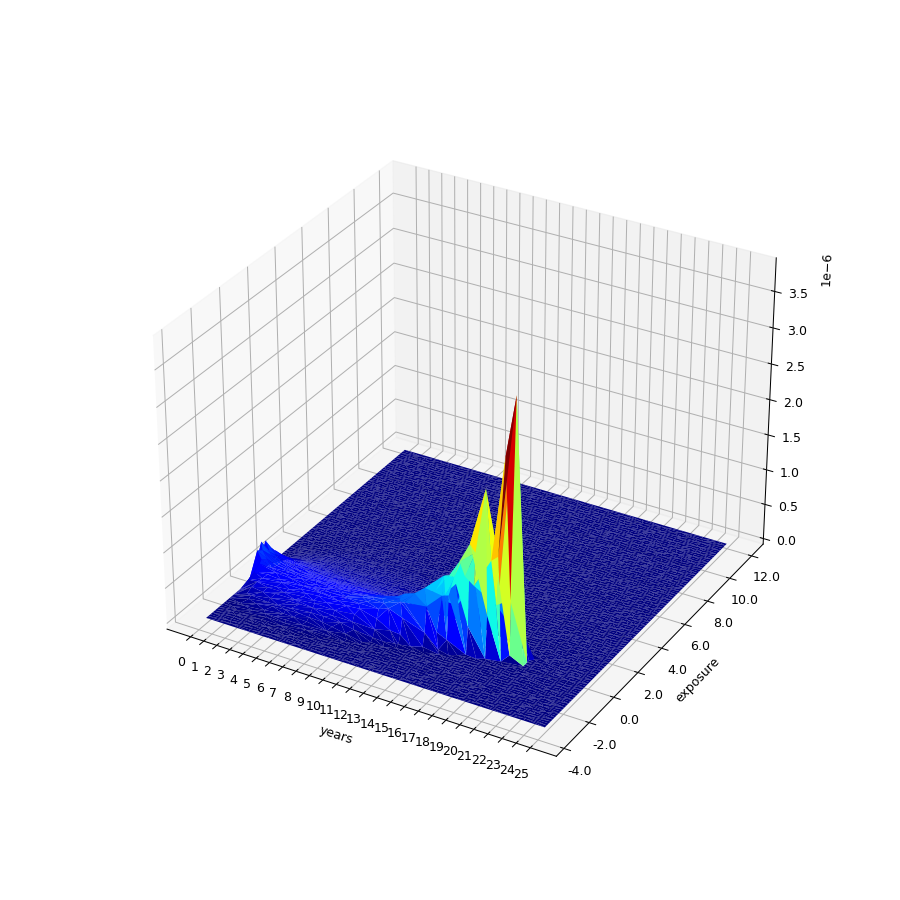

In [133]:
fig_surface = plt.figure(figsize=(10,10))
#fig_surface.clear()
ax_surface = fig_surface.add_subplot(111, projection='3d')
date_step = 4
ax_surface.set_xticks(years[::date_step])
ax_surface.set_xticklabels(years[::date_step])
ax_surface.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: "{:,.0f}".format(x)))
ax_surface.set_xlabel('years')

ax_surface.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: "{:,.1f}".format(x/1000000)))
ax_surface.set_ylabel("exposure")
X, Y = np.meshgrid(years, dist_space)
ax_surface.plot_trisurf(X.flatten(), Y.flatten(),
density_values.T.flatten(), cmap=cm.jet, linewidth=0)



In [135]:
df.groupby(['Date','DateIndex']).mean("Value").reset_index()[:10]


,Date,DateIndex,Sample,Depth,Value
0,2016-02-05,0,0.0,0.0,597.956400
1,2016-05-06,1,5000.5,0.0,1639.623937
2,2016-08-05,2,5000.5,0.0,838.587250
3,2016-11-07,3,5000.5,0.0,102266.475773
4,2017-02-06,4,5000.5,0.0,101388.249997
5,2017-05-05,5,5000.5,0.0,550.064602
6,2017-08-07,6,5000.5,0.0,-88.413012
7,2017-11-06,7,5000.5,0.0,97710.464965
8,2018-02-05,8,5000.5,0.0,96750.843065
9,2018-05-08,9,5000.5,0.0,-1362.091691


<IPython.core.display.Javascript object>


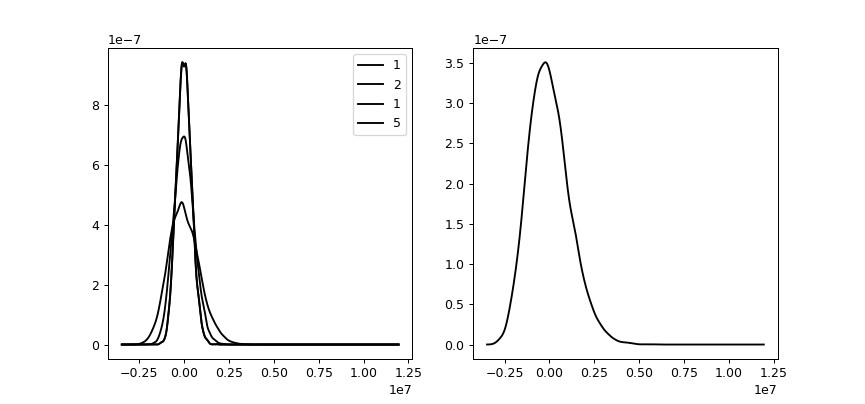

In [149]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4), dpi=100)

#fig_surface = plt.figure()
#splot = fig_surface.add_subplot(211)
def getdist(nrow):
    return df_surface.loc[df_surface['DateIndex'] == nrow, 'Value']


#grid = np.arange(npv_min,npv_max,100)
#row1 = getdist(nrow =40)
#density1 = gaussian_kde(row1.values)
#splot.plot(grid,density(grid), color='k', label="40")


density1 = gaussian_kde(getdist(nrow =1).values)
ax1.plot(grid,density1(grid), color='k', label="1")
density2 = gaussian_kde(getdist(nrow =2).values)
ax1.plot(grid,density2(grid), color='k', label="2")
ax1.plot(grid,density1(grid), color='k', label="1")
density5 = gaussian_kde(getdist(nrow =5).values)
ax1.plot(grid,density5(grid), color='k', label="5")
ax1.legend()


density10 = gaussian_kde(getdist(nrow =10).values)
ax2.plot(grid,density10(grid), color='k', label="10")
#splot.legend()

In [137]:
xva_filename = "C:\\Users\\fhoefer\\source\\repos\\ore\\Examples\\ExamplePVSwap\\Output\\xva.csv"
df_xva = pd.read_csv(xva_filename)
df_xva


,#TradeId,NettingSetId,CVA,DVA,FBA,FCA,FBAexOwnSP,FCAexOwnSP,FBAexAllSP,FCAexAllSP,...,OurKVACCR,TheirKVACCR,OurKVACVA,TheirKVACVA,CollateralFloor,AllocatedCVA,AllocatedDVA,AllocationMethod,BaselEPE,BaselEEPE
0,NaN,CPTY_A,43415.32,62418.92,30452.16,-4516.95,34742.53,-5165.22,37674.18,-5609.63,...,0.0,0.0,0.0,0.0,0.0,43415.32,62418.92,None,183056.83,183056.83
1,Swap_20y,CPTY_A,43415.32,62418.92,30452.16,-4516.95,34742.53,-5165.22,37674.18,-5609.63,...,NaN,NaN,NaN,NaN,NaN,0.00,0.00,None,183056.83,183056.83
